# Non-interacting dimer tutorial

In this notebook we will look at the response functions of the non-interacting dimer system 

$$
\hat{H} = -V \sum_\sigma (c^\dagger_{0\sigma} c_{1\sigma} + c^\dagger_{1\sigma} c_{0\sigma})
$$

with two fermionic levels that are hybridized by the coupling $V$ which we take as our unit of energy $V=1$.

Since there is no interaction applying many-body exact diagonalization on this system is not required. But we will anyhow use `pyed` to investigate the system.

Setting up the Hamiltonian can be done using `triqs` operators according to

In [5]:
from pytriqs.operators import c, c_dag
up, do = 0, 1

V = 1.0
H = -V*(c_dag(up, 0)*c(up, 1) + c_dag(up, 1)*c(up, 0) + \
        c_dag(do, 0)*c(do, 1) + c_dag(do, 1)*c(do, 0) )

print 'H =', H

H = -1*C^+(0,0)C(0,1) + -1*C^+(0,1)C(0,0) + -1*C^+(1,0)C(1,1) + -1*C^+(1,1)C(1,0)


We then pass the Hamiltonian $\hat{H}$ on to `pyed` and diagonalize the system at a finite inverse temperature $\beta = 10$.

In [16]:
beta = 10.0 # inverse temperature
fundamental_operators = [c(up, 0), c(down, 0), c(up, 1), c(down, 1)]

from pyed.TriqsExactDiagonalization import TriqsExactDiagonalization
ed = TriqsExactDiagonalization(H, fundamental_operators, beta)

print r'Z =', ed.get_partition_function()
print r'\Omega =', ed.get_free_energy()

Z = 1.00018161209
\Omega = -2.00001815956


We compute the imagnary time single particle Green's function of the system $G_{ij}(\tau) = - \langle \mathcal{T} c_{i\sigma}(\tau) c^\dagger_{j\sigma} \rangle$ for both sites $i,j = (0,0),(0,1), (1,0), (1,1)$ and plot them.

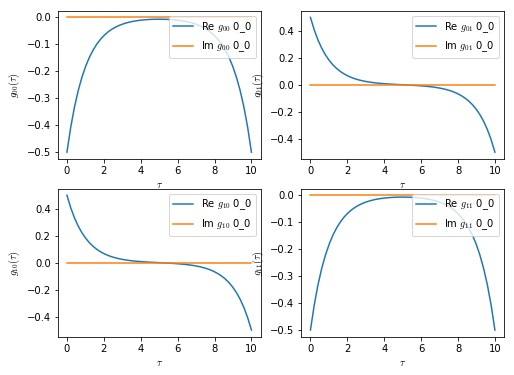

In [17]:
import itertools
from pytriqs.gf import GfImTime
import matplotlib.pyplot as plt
from pytriqs.plot.mpl_interface import oplot

plt.figure(figsize=(8, 6))
subp = [2, 2, 1]
for i1, i2 in itertools.product(range(2), repeat=2):
    g_tau = GfImTime(name=r'$g_{%i%i}$' % (i1, i2), beta=beta, 
                     statistic='Fermion', n_points=50, target_shape=(1,1))
    ed.set_g2_tau(g_tau, c(up, i1), c_dag(up, i2))
    plt.subplot(*subp); subp[-1] += 1
    oplot(g_tau)
    
plt.show()

To understand the structure of $G(\tau)$, in particular why the offidagonal terms change sign, we can transform to the eigen basis of the dimer system and solve it by hand.


The dimer Hamitonian can be brought to matrix form using the Nambu operator $\Psi^\dagger_\sigma = (c^\dagger_{0\sigma}, c^\dagger_{1\sigma})$, which enable us to write $\hat{H}$ as

$$
\hat{H} = 
\sum_\sigma
\Psi^\dagger_\sigma
\left[ \begin{array}{c}
0 & -V \\
-V & 0 
\end{array} \right]
\Psi_\sigma
\equiv
\sum_\sigma
\Psi^\dagger_\sigma
h
\Psi_\sigma
$$

Where we have defined the single particle matrix $h$. Now, by applying the unitary single-particle basis transformation 

$$
U_{ij} = 
\frac{1}{\sqrt{2}}
\left[\begin{array}{c}
-1 & -1 \\
-1 & 1 
\end{array}\right]
$$

to $h$ we can bring this matrix to diagonal form. Lets define the second-quantized operators $d_{i\sigma}$ in the transformed basis as

$$
c_{i\sigma} = \sum_{j} U_{ij} d_{j\sigma}
$$

In the transformed basis the system now comprise two separate states

$$
\hat{H} = \sum_\sigma \Big[ -V d^\dagger_{0\sigma} d_{0\sigma} + V d^\dagger_{1\sigma} d_{1\sigma} \Big] 
$$

The corresponding single-particle Green's functions can be determined analytically as

$$
g(\tau) = e^{\pm V \tau} (1 - f(\pm V))
$$

where $f(\epsilon) = (e^{\beta \epsilon} + 1)$.

However, we instead solve this decoupled system using `pyed` below


In [38]:
H = -V*(c_dag(up, 0)*c(up, 0) + c_dag(do, 0)*c(do, 0)) + \
    +V*(c_dag(up, 1)*c(up, 1) + c_dag(do, 1)*c(do, 1))
print 'H =', H
ed = TriqsExactDiagonalization(H, fundamental_operators, beta)



H = -1*C^+(0,0)C(0,0) + 1*C^+(0,1)C(0,1) + -1*C^+(1,0)C(1,0) + 1*C^+(1,1)C(1,1)


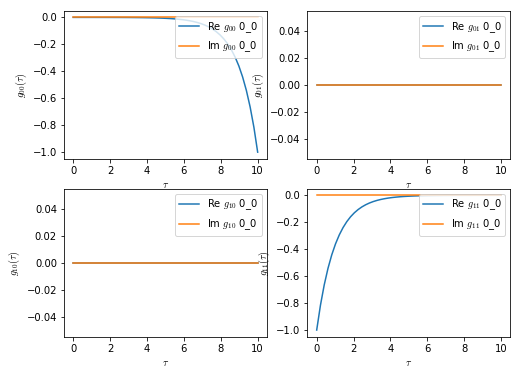

In [39]:
plt.figure(figsize=(8, 6))
subp = [2, 2, 1]

import numpy as np
gmat = np.empty((2, 2), dtype=np.object)

for i1, i2 in itertools.product(range(2), repeat=2):
    g_tau = GfImTime(name=r'$g_{%i%i}$' % (i1, i2), beta=beta, 
                     statistic='Fermion', n_points=50, target_shape=(1,1))
    ed.set_g2_tau(g_tau, c(up, i1), c_dag(up, i2))
    gmat[i1, i2] = g_tau
    plt.subplot(*subp); subp[-1] += 1
    oplot(g_tau)
    
plt.show()

Above we see that the Green's function is diagonal and given by two exponential functions $\propto e^{\pm V \tau}$ as anticipated.

Now we can connect back to the original dimer system by simply transforming this diagonal Green's function back to the dimer basis, using the uniary transform $U$ defined above.

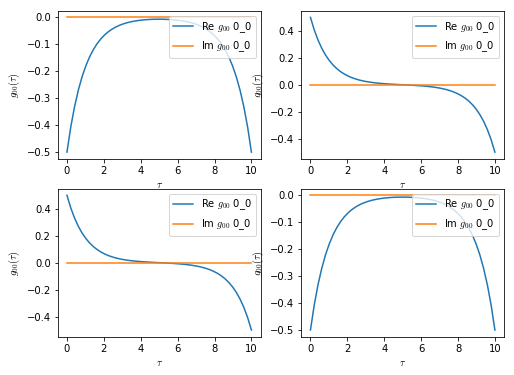

In [40]:
# Unitary transform matrix

U = np.array([
    [-1, -1],
    [-1, +1],
    ]) / np.sqrt(2)

gmat_trans = np.mat(U) * np.mat(gmat) * np.mat(U).H

plt.figure(figsize=(8, 6))
subp = [2, 2, 1]

for i1, i2 in itertools.product(range(2), repeat=2):
    plt.subplot(*subp); subp[-1] += 1
    oplot(gmat_trans[i1, i2])
    
plt.show()

We see that this transform reproduces the Green's function from the direct calculation of the dimer system, and in particular we see that the sign-changning off diagonal terms are given by linear combinations of the exponential Green's functions $g$ in the diagonal basis, i.e.

$$
G_{01} \propto g_{00} - g_{11}
$$
